# Classifier performance

Let's return to the classifier for the loan applications data set.

In [1]:
import numpy as np
from sklearn import neighbors,metrics
from sklearn.model_selection import train_test_split

X = np.loadtxt("data.csv",delimiter=",")
n,d = X.shape
y = np.loadtxt("labels.csv",delimiter=",")

X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2)

knn = neighbors.KNeighborsClassifier(n_neighbors=11)   
knn.fit(X_tr,y_tr) 
acc = knn.score(X_te,y_te)
print(f"accuracy is {acc:.1%}")

accuracy is 78.5%


Is this good accuracy? Welp, consider that the vast majority of loans were funded:

In [2]:
funded = sum(y==-1)
print(f"{funded/n:.1%} were funded")

81.6% were funded


Therefore, an algorithm that simply "predicts" funding every loan would do nearly as well as the trained classifier!

In [3]:
from sklearn import metrics
acc = metrics.accuracy_score(y_te,[-1]*len(y_te))
print(f"fund-em-all accuracy is {acc:.1%}")

fund-em-all accuracy is 77.2%


By comparison, our trained classifier is not impressive at all. We need a metric other than accuracy to detect that, apparently.

## Binary classifiers

Recall that a binary classifier is one that produces just two unique labels, which we call "yes" and "no" here.
To fully understand the performance of a binary classifier, we have to account for four cases:

* True positives (TP): Predicts "yes", actually is "yes"
* False positives (FP): Predicts "yes", actually is "no"
* True negatives (TN): Predicts "no", actually is "no"
* False negatives (FN): Predicts "no", actually is "yes"

The four cases correspond to a 2×2 table according to the states of the prediction and *ground truth*, which is the accepted correct value (the given label). The table can be filled with counts or percentages of tested instances, to create a **confusion matrix**, as illustrated in {numref}`fig-supervised-confusion`. 

```{figure} confusion.svg
---
name: fig-supervised-confusion
---
Confusion matrix
```

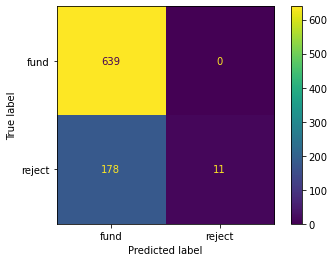

In [4]:
yhat = knn.predict(X_te)
C = metrics.confusion_matrix(y_te,yhat,labels=[-1,1])
lbl = ["fund","reject"]
metrics.ConfusionMatrixDisplay(C,display_labels=lbl).plot();

Hence there are 656 true positives (funded) and 12 true negatives (rejected). Therefore, the **accuracy** is 

$$
\newcommand{TP}{\text{TP}}
\newcommand{FP}{\text{FP}}
\newcommand{TN}{\text{TN}}
\newcommand{FN}{\text{FN}}
\text{accuracy} = \frac{\TP + \TN}{\TP + \FP + \TN + \FN} = \frac{680}{828} = 0.821256\ldots,
$$

i.e., 82.1%. However, there are four other quantities defined by putting a "number correct" value in the numerator and a sum of a row or column in the denominator:

$$
\text{recall (aka sensitvity)} &= \frac{\TP}{\TP + \FN} \\[2mm]
\text{specificity} &= \frac{\TN}{\TN + \FP} \\[2mm] 
\text{precision} &= \frac{\TP}{\TP + \FP} \\[2mm] 
\text{negative predictive value (NPV)} &= \frac{\TN}{\TN + \FN} \\ 
$$

In words, these metrics answer the following questions:

* **recall** How often are actual "yes" cases predicted correctly?
* **specificity** How often are actual "no" cases predicted correctly?
* **precision** How often are the "yes" predictions correct?
* **NPV** How often are the "no" predictions correct?

For our loan classifier, here are the scores:

In [5]:
TP,FN,FP,TN = C.ravel()
print(f"recall = {TP/(TP+FN):.1%}")
print(f"specificity = {TN/(TN+FP):.1%}")
print(f"precision = {TP/(TP+FP):.1%}")
print(f"NPV = {TN/(TN+FN):.1%}")

recall = 100.0%
specificity = 5.8%
precision = 78.2%
NPV = 100.0%


The recall is almost perfect: virtually nobody who should get a loan will go away disappointed. However, the low specificity would be concerning to those doing the funding, because 95% who should be rejected will be funded as well. (It's now clear that the trained classifier is barely different from the "fund them all" one.)

There are numerous ways to combine these measures into a single number other than standard accuracy. None is universally best, because different applications emphasize different aspects of performance. One of the most popular is the **$F_1$ score**, which is the harmonic mean of the precision and the recall:

$$
\left[ \frac{1}{2} \left(\frac{\TP + \FN}{\TP} + \frac{\TP+\FP}{\TP} \right)  \right]^{-1} = \frac{2\TP}{2\TP+\FN+\FP}.
$$

This score varies between zero (poor) and one (ideal). 

You may know the harmonic mean as the operation for wiring electrical resistors in parallel. If one of the quantities is much smaller than the other, their harmonic mean will be close to the small value. Thus, $F_1$ score punishes a classifier if either recall or precision is poor. 

Another composite score is **balanced accuracy**, which is the mean of recall and specificity. It also ranges from 0 to 1, with 1 meaning perfect accuracy.

In [6]:
print("F1:",metrics.f1_score(y_te,yhat))
print("Balanced:",metrics.balanced_accuracy_score(y_te,yhat))

F1: 0.11
Balanced: 0.5291005291005291


The loan classifier trained above has excellent recall, respectable precision, and terrible specificity, resulting in a good $F_1$ score and a low balanced accuracy score.

```{prf:example}
Inspired by the high funding rate, suppose we try a "classifier" that funds every loan. Then 

$$
\TP = k,\, \TN = 0,\, \FP = n-k,\, \FN = 0.
$$

Its $F_1$ score is thus

$$
\frac{2\TP}{2\TP+\FN+\FP} = \frac{2k}{2k+n-k} = \frac{2k}{k+n},
$$

and its balanced accuracy is 

$$
\frac{1}{2} \left(\frac{\TP}{\TP+\FN} + \frac{\TN}{\TN+\FP} \right)  = \frac{1}{2}.
$$

If the fraction of funded samples in the test set is $k/n=a$, then the $F_1$ score is $a/(1+a)$, which increases smoothly from zero to one as $a$ does. For the loan problem, $a=0.816$ and the $F_1$ of this lazy classifier is $0.449$. 
```

<!-- 
print("F1:",metrics.cohen_kappa_score(y_te,yhat))
print("F1:",metrics.matthews_corrcoef(y_te,yhat)) -->

The point is that each individual metric gives part of the picture, but it can be misleading depending on what behavior an application values most.

## Multiclass classifiers

When there are more than two unique possible labels, these measures can be extended using the **one-vs-rest** paradigm. For $K$ unique labels, this paradigm poses $K$ binary questions: "Is it in class 1, or not?", "Is it in class 2, or not?", etc. This produces $K$ versions of metrics such as accuracy, recall, $F_1$-score, and so on, which can be averaged to give a single score. There are various ways to perform the averaging, depending on whether poorly represented classes are to be weighted more weakly than others. We won't give the details.

The confusion matrix also generalizes to $K$ classes. It's easiest to see how by an example. We will use a well-known data set derived from automatic recognition of handwritten digits from 0 to 9.

(n,d) = (1437, 64)


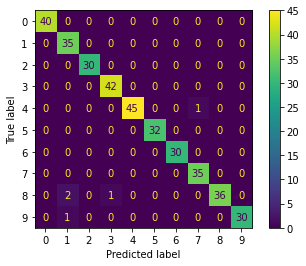

In [7]:
from sklearn import datasets
digits = datasets.load_digits()
X = digits.data
y = digits.target
X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.2)
print("(n,d) =",X_tr.shape)

knn = neighbors.KNeighborsClassifier(n_neighbors=16)
knn.fit(X,y)
yhat = knn.predict(X_te)

C = metrics.confusion_matrix(y_te,yhat)
metrics.ConfusionMatrixDisplay(C).plot();

From the confusion matrix, we can see that, for example, the detection of "1" in the test set gives 35 true positives and a total of 3 false positives. Therefore, that precision is $35/38=92.1$%. We can get all the individual precision scores automatically.

In [8]:
prec = metrics.precision_score(y_te,yhat,average=None)
print([f"{p:.1%}" for p in prec])

['100.0%', '92.1%', '100.0%', '97.7%', '100.0%', '100.0%', '100.0%', '97.2%', '100.0%', '100.0%']


To get a composite precision score, we have to specify an averaging method. The `"macro"` option simply takes the mean of the vector above.

In [9]:
mac = metrics.precision_score(y_te,yhat,average="macro")
print([mac,prec.mean()])

[0.9870019039847682, 0.9870019039847682]


When the classes are not well-balanced, you might want to choose a different averaging method.